Ignore this first cell; I'm using someone else's code to give the cells I haven't modified a light grey background. This is to help both you and myself distinguish between the code that matters and the code that doesn't.

In [1]:
from IPython.display import HTML, display

def set_background(color):
    script = (
        "var cell = this.closest('.code_cell');"
        "var editor = cell.querySelector('.input_area');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

---

In [2]:
set_background('#d3d3d3')

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


def sampling(args):
    """
    Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
set_background('#d3d3d3')

(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
input_shape = x_train[0].shape
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))

print("We loaded the MNIST dataset:")
print("input_shape:", input_shape)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

We loaded the MNIST dataset:
input_shape: (28, 28)
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


I first store the names of all the activation functions as well as the names of all the optimizers. I didn't end up using the latter in this final version of the notebook.

In [4]:
import tensorflow.keras.activations

tensorflow_keras_activations = tensorflow.keras.activations
activation_function_names = []

for name in dir(tensorflow_keras_activations):
    if name[0] != '_':
        activation_function_names.append(name)
        print('\'' + name + '\' appended')

'deserialize' appended
'elu' appended
'exponential' appended
'gelu' appended
'get' appended
'hard_sigmoid' appended
'linear' appended
'relu' appended
'selu' appended
'serialize' appended
'sigmoid' appended
'softmax' appended
'softplus' appended
'softsign' appended
'swish' appended
'tanh' appended


In [5]:
import tensorflow.keras.optimizers

tensorflow_keras_optimizers = tensorflow.keras.optimizers
optimizer_names = []

for name in dir(tensorflow_keras_optimizers):
    if name[0].isupper() and name != 'Optimizer':   # Filters out class methods (e.g., get)
                                                    # and the Optimizer abstract base class
        optimizer_names.append(name)
        print('\'' + name + '\' appended')

'Adadelta' appended
'Adagrad' appended
'Adam' appended
'Adamax' appended
'Ftrl' appended
'Nadam' appended
'RMSprop' appended
'SGD' appended


The following three cells are essentially the same code provided for this week's homework, wrapped in a series of for loops with slight modifications to repeat the training process across all activation functions.

In [6]:
model_data = []

for activation_function_name in activation_function_names:
#   for i in range(len(optimizer_names)):
        try:
            input_shape = (28, 28, 1)
            latent_dim = 32

            inputs = Input(shape=input_shape, name='encoder_input')

            kernels = 26

            x = Conv2D(kernels, (3), activation=activation_function_name, padding='same')(inputs)
            x = MaxPooling2D((2), padding='same')(x)
            x = Conv2D(int(kernels / 2), (3), activation=activation_function_name, padding='same')(x)
            x = MaxPooling2D((2), padding='same')(x)
            x = Conv2D(int(kernels / 4), (3), activation=activation_function_name, padding='same')(x)
            x = MaxPooling2D((2), padding='same')(x)
            intermediate_conv_shape = x.get_shape()
            x = Flatten()(x)

            x = BatchNormalization()(x)
            x = Activation(activation_function_name)(x)

            _, n, m, o = intermediate_conv_shape
            intermediate_dim = n * m * o

            z_mean = Dense(latent_dim, name='z_mean')(x)
            z_log_var = Dense(latent_dim, name='z_log_var')(x)

            z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

            encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

            latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
            x = Dense(intermediate_dim, activation=activation_function_name)(latent_inputs)

            x = BatchNormalization()(x)
            x = Activation(activation_function_name)(x)

            x = Reshape((n, m, o))(x)
            x = Conv2D(int(kernels / 4), (3), activation=activation_function_name, padding='same')(x)
            x = UpSampling2D((2))(x)
            x = Conv2D(int(kernels / 2), (3), activation=activation_function_name, padding='same')(x)
            x = UpSampling2D((2))(x)
            x = Conv2D(int(kernels), (3), activation=activation_function_name)(x)
            x = UpSampling2D((2))(x)
            outputs = Conv2D(1, (3), activation=activation_function_name, padding='same')(x)

            decoder = Model(latent_inputs, outputs, name='decoder')

            outputs = decoder(encoder(inputs)[2])
            vae = Model(inputs, outputs, name='vae_mlp')

            # Here, I'm storing all the variables involved in the creation of each model
            # in their order of appearence in the ongoing for loop.
            # I realise that not all variables are necessary to store but this is easier.
            model_data.append((
                input_shape,
                latent_dim,
                inputs,
                kernels,
                x,
                intermediate_conv_shape,
                _,n,m,o,
                intermediate_dim,
                z_mean,
                z_log_var,
                z,
                encoder,
                latent_inputs,
                outputs,
                decoder,
                outputs,
                vae
            ))
        except:
            continue # Skip method names (deserialize, get, serialize)

In [7]:
# from itertools import cycle

# current_optimizer = cycle(optimizer_names)

for (
    input_shape,
    latent_dim,
    inputs,
    kernels,
    x,
    intermediate_conv_shape,
    _,n,m,o,
    intermediate_dim,
    z_mean,
    z_log_var,
    z,
    encoder,
    latent_inputs,
    outputs,
    decoder,
    outputs,
    vae
) in model_data:
    args_mse = False
    if args_mse:
        reconstruction_loss = mse(inputs, outputs)
    else:
        reconstruction_loss = binary_crossentropy(inputs, outputs)

    m = input_shape[0] * input_shape[1]
    reconstruction_loss *= m
    reconstruction_loss = K.sum(reconstruction_loss)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae_loss /= m
    vae_loss /= m
    vae.add_loss(vae_loss)

#   vae.compile(optimizer=next(current_optimizer))
    vae.compile(optimizer='Adam')

In [8]:
import time

batch_size = 128
epochs = 10

histories = []

start_time = time.time()

for (
    input_shape,
    latent_dim,
    inputs,
    kernels,
    x,
    intermediate_conv_shape,
    _,n,m,o,
    intermediate_dim,
    z_mean,
    z_log_var,
    z,
    encoder,
    latent_inputs,
    outputs,
    decoder,
    outputs,
    vae
) in model_data:
    histories.append(vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None)))

end_time = time.time()
elapsed_time = (end_time - start_time)
print('Elapsed time: ', elapsed_time, 's')

Epoch 1/10
469/469 [==============================] - 112s 233ms/step - loss: 57.7391 - val_loss: 42.3733
Epoch 2/10
469/469 [==============================] - 106s 227ms/step - loss: 45.3363 - val_loss: 37.8171
Epoch 3/10
469/469 [==============================] - 107s 228ms/step - loss: 35.5180 - val_loss: 40.6865
Epoch 4/10
469/469 [==============================] - 104s 221ms/step - loss: 32.0321 - val_loss: 28.8691
Epoch 5/10
469/469 [==============================] - 103s 219ms/step - loss: 28.6304 - val_loss: 26.7083
Epoch 6/10
469/469 [==============================] - 106s 225ms/step - loss: 29.7500 - val_loss: 28.4960
Epoch 7/10
469/469 [==============================] - 104s 222ms/step - loss: 27.7564 - val_loss: 29.1484
Epoch 8/10
469/469 [==============================] - 106s 226ms/step - loss: 26.1691 - val_loss: 24.2200
Epoch 9/10
469/469 [==============================] - 105s 225ms/step - loss: 29.6611 - val_loss: 26.8896
Epoch 10/10
469/469 [=========================

Epoch 9/10
469/469 [==============================] - 106s 226ms/step - loss: 16.1234 - val_loss: 16.5550
Epoch 10/10
469/469 [==============================] - 107s 229ms/step - loss: 15.8795 - val_loss: 16.7299
Epoch 1/10
469/469 [==============================] - 105s 220ms/step - loss: 55.7874 - val_loss: 50.4602
Epoch 2/10
469/469 [==============================] - 104s 222ms/step - loss: 37.4027 - val_loss: 33.7566
Epoch 3/10
469/469 [==============================] - 103s 219ms/step - loss: 33.2763 - val_loss: 32.6042
Epoch 4/10
469/469 [==============================] - 104s 223ms/step - loss: 32.7553 - val_loss: 32.3999
Epoch 5/10
469/469 [==============================] - 106s 226ms/step - loss: 32.3429 - val_loss: 31.9675
Epoch 6/10
469/469 [==============================] - 103s 220ms/step - loss: 31.7575 - val_loss: 31.2699
Epoch 7/10
469/469 [==============================] - 102s 218ms/step - loss: 31.5690 - val_loss: 31.2525
Epoch 8/10
469/469 [=========================

The cell below is self-explanatory.

In [9]:
activation_function_names.remove('deserialize')
activation_function_names.remove('get')
activation_function_names.remove('serialize')

I now compare loss and val_loss across all activation functions per epoch through a set of line plots.

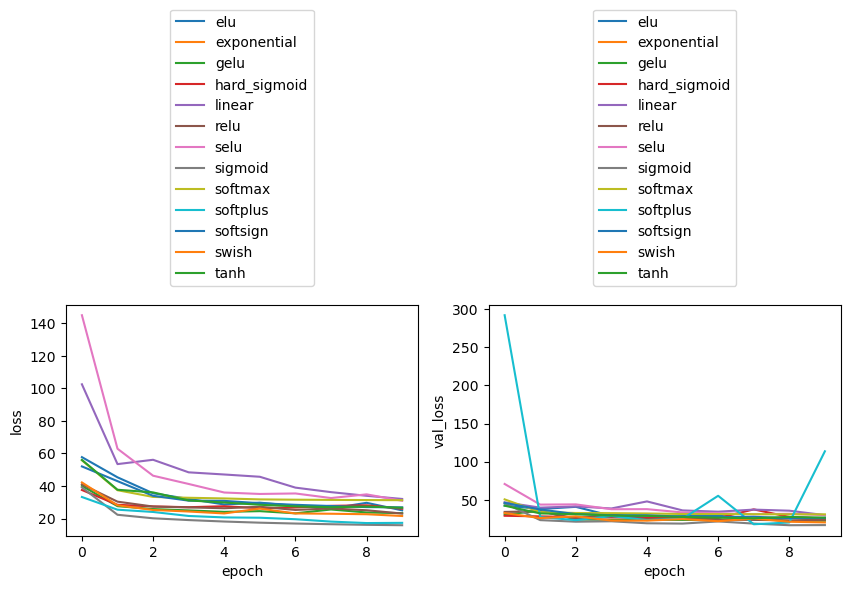

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('val_loss')

epochs_array = list(range(epochs))
for history, activation_function_name in zip(histories, activation_function_names):
    ax1.plot(epochs_array, history.history['loss'], label=activation_function_name)
    ax2.plot(epochs_array, history.history['val_loss'], label=activation_function_name)

ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05))
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05))

plt.show()

The cell below contains selected lines from the example provided for this week's homework.

In [11]:
x1 = x_test[73]
x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)

1/1 [==============================] - 0s 120ms/step


The final cell is a modified version of the reconstruction code provided for this week's homework.

1/1 [==============================] - 0s 140ms/step


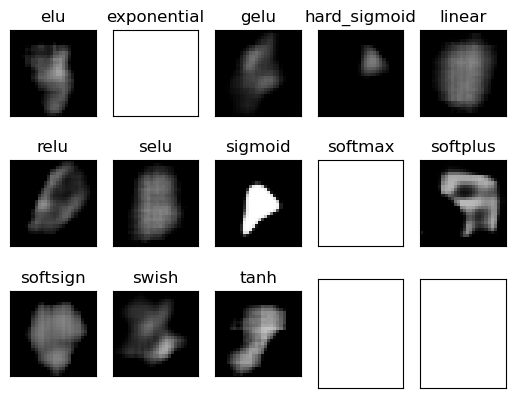

In [12]:
fig_, axarr = plt.subplots(3, 5)

last_index = 0
quit = False
for i in range(3):
    if quit == True:
        break
    for j in range(5):
        if last_index == 13:
            quit = True
            break
        
        y1 = model_data[last_index][17].predict(z)
        y1 = y1[0]
        img = y1[:,:,0]

        axarr[i][j].imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
        axarr[i][j].set_title(activation_function_names[last_index])

        axarr[i][j].set_xticks([])
        axarr[i][j].set_yticks([])

        last_index += 1

for i, j in zip([2, 2], [3, 4]):
    axarr[i][j].set_xticks([])
    axarr[i][j].set_yticks([])

plt.show()